In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

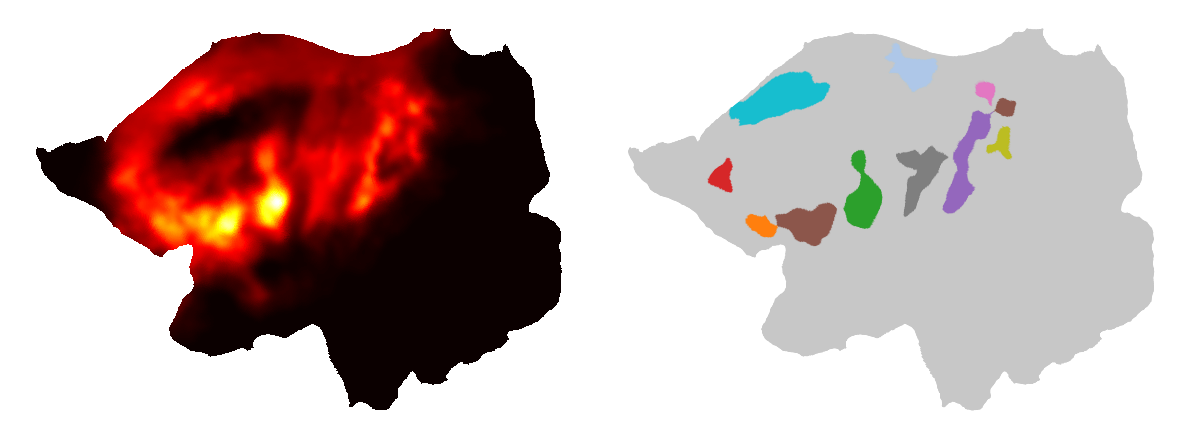

(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

In [ ]:
import os
from cluster_surface import cluster_surface, visualize_clusters

surf = os.path.join("/Users/dchaimow/data/test_cluster_surface","colin.cerebral.L.flat.164k_fs_LR.surf.gii")
metric = os.path.join("/Users/dchaimow/data/test_cluster_surface","smoothed_glm_bold_fstat.func.gii")

min_cluster_size=200    # minimum cluster size in mm^2 (default: 100 mm^2)
min_abs_value=1         # minimum z-score (default: mean of absolute values)
negative=False          # whether to consider negative clusters (default: False)

clusters = cluster_surface(metric, surf,
                           min_cluster_size=min_cluster_size,
                           min_abs_value=min_abs_value,
                           negative=negative)
visualize_clusters(clusters, metric, surf)
plt.show()

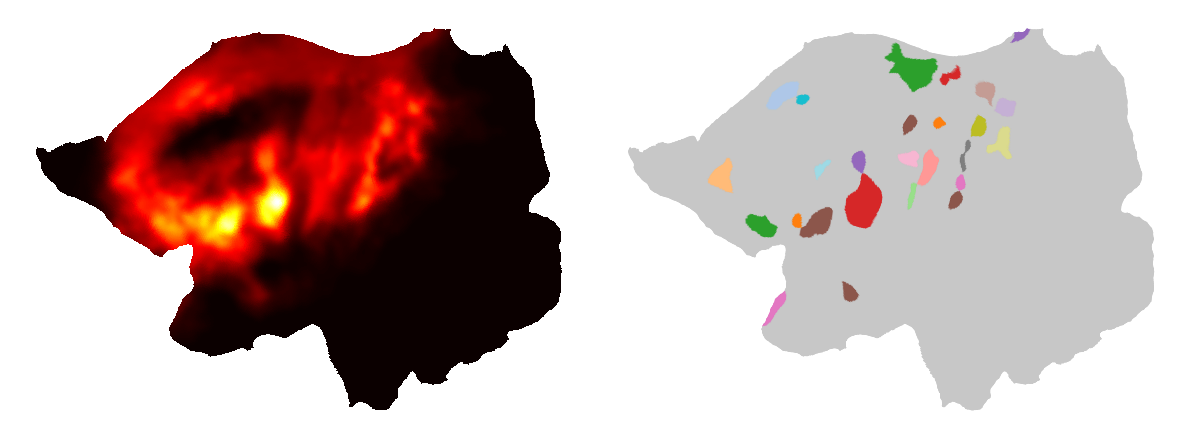

In [15]:
import os
from cluster_surface import cluster_surface, visualize_clusters

surf = os.path.join("/Users/dchaimow/data/test_cluster_surface","colin.cerebral.L.flat.164k_fs_LR.surf.gii")
metric = os.path.join("/Users/dchaimow/data/test_cluster_surface","smoothed_glm_bold_fstat.func.gii")

clusters = cluster_surface(metric, surf)
visualize_clusters(clusters, metric, surf)


In [13]:
surf

'/Users/dchaimow/data/test_cluster_surface/colin.cerebral.L.flat.164k_fs_LR.surf.gii'

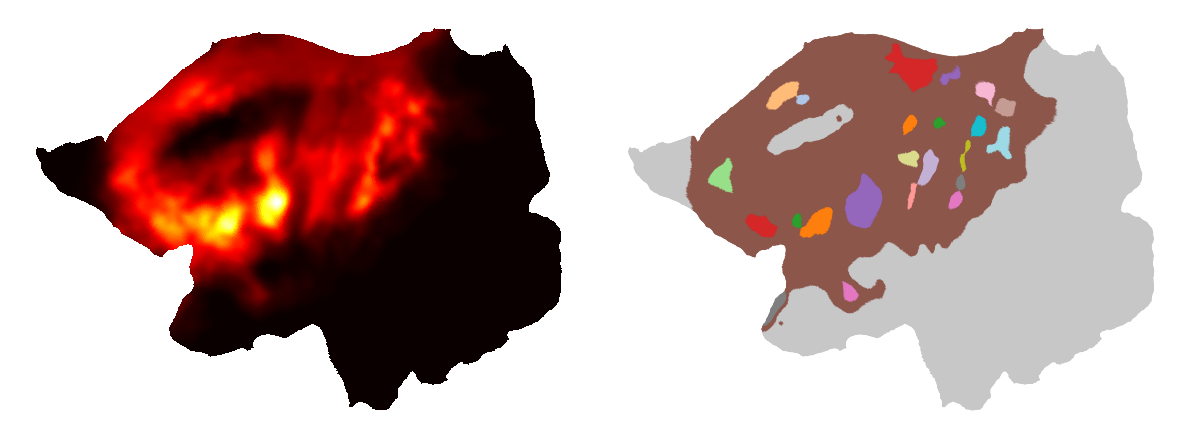

In [6]:
# read gifti surface in file surf_path using nibabel
import nibabel as nib
surf_gii = nib.load(surf)
vertices = surf_gii.darrays[0].data
faces = surf_gii.darrays[1].data    
n_vertices = vertices.shape[0]
n_faces = faces.shape[0]
surf = dict(vertices=vertices, faces=faces)

In [2]:
import os
import nibabel as nib
import numpy as np
import nilearn.plotting as plotting
import matplotlib.pyplot as plt

In [3]:
surf_map_path = os.path.join("/Users/dchaimow/data/test_cluster_surface",
                                 "smoothed_glm_bold_fstat.func.gii")
surf_path = os.path.join("/Users/dchaimow/data/test_cluster_surface",
                                 "colin.cerebral.L.flat.164k_fs_LR.surf.gii")

In [5]:
surf_map_gii = nib.load(surf_map_path)
surf_map_data = surf_map_gii.agg_data()


# get the indices of sorted values of surf_map_data,
# Ignore NaN values when sorting
valid_mask = ~np.isnan(surf_map_data)
sorted_vertices = np.argsort(surf_map_data[valid_mask])[-1::-1]  # Sort in descending order
# Map back to original indices
sorted_vertices = np.where(valid_mask)[0][sorted_vertices]

# read gifti surface in file surf_path using nibabel
surf_gii = nib.load(surf_path)
vertices = surf_gii.darrays[0].data
faces = surf_gii.darrays[1].data    
n_vertices = vertices.shape[0]
n_faces = faces.shape[0]
surf = dict(vertices=vertices, faces=faces)

In [6]:
def calc_vertex_area(surf):
    """
    Calculate the vertex area for a given surface mesh.
    
    Parameters
    ----------
    surf : dict
        Dictionary containing 'vertices' and 'faces' of the surface mesh.
    
    Returns
    -------
    area : np.ndarray
        Array of vertex areas.
    """
    vertices = surf['vertices']
    faces = surf['faces']
    
    # Calculate the area of each face using the cross product
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    
    face_areas = np.linalg.norm(np.cross(v1 - v0, v2 - v0), axis=1) / 2.0
    
    # Initialize vertex area array
    area = np.zeros(vertices.shape[0], dtype=np.float32)
    
    # Accumulate face areas to corresponding vertices
    for i in range(faces.shape[0]):
        area[faces[i]] += face_areas[i] / 3.0  # Each vertex contributes equally to the face area
    
    return area

In [8]:
calc_vertex_area(surf)

array([0.4705538 , 1.543956  , 0.4206287 , ..., 0.36281687, 0.36215982,
       0.3153462 ], shape=(163842,), dtype=float32)

In [9]:
area_path = os.path.join("/Users/dchaimow/data/test_cluster_surface",
                                 "area.L.shape.gii")
area_gii = nib.load(area_path)
area_data = area_gii.agg_data()

In [10]:
area_data

array([0.47055382, 1.543956  , 0.4206287 , ..., 0.36281696, 0.36215982,
       0.3153462 ], shape=(163842,), dtype=float32)

In [9]:
# def precompute_connectivity_matrix(vertices, faces):
#     """
#     Precompute the connectivity matrix for the surface mesh.
#     """
#     n_vertices = vertices.shape[0]
#     connectivity_matrix = np.zeros((n_vertices, n_vertices), dtype=bool)
    
#     for face in faces:
#         connectivity_matrix[face[0], face[1]] = True
#         connectivity_matrix[face[1], face[0]] = True
#         connectivity_matrix[face[0], face[2]] = True
    
#     return connectivity_matrix

In [10]:
def precompute_connectivity_list(vertices, faces):
    """
    Precompute the connectivity list for the surface mesh.
    """
    n_vertices = vertices.shape[0]
    connectivity_list = [[] for _ in range(n_vertices)]
    
    for face in faces:
        connectivity_list[face[0]].append(face[1])
        connectivity_list[face[0]].append(face[2])
        connectivity_list[face[1]].append(face[0])
        connectivity_list[face[1]].append(face[2])
        connectivity_list[face[2]].append(face[0])
        connectivity_list[face[2]].append(face[1])
    
    return connectivity_list

In [11]:
# def precompute_connectivity_dict(vertices, faces):
#     """
#     Precompute the connectivity dictionary for the surface mesh.
#     """
#     n_vertices = vertices.shape[0]
#     connectivity_dict = {i: [] for i in range(n_vertices)}
    
#     for face in faces:
#         connectivity_dict[face[0]].append(face[1])
#         connectivity_dict[face[0]].append(face[2])
#         connectivity_dict[face[1]].append(face[0])
#         connectivity_dict[face[1]].append(face[2])
#         connectivity_dict[face[2]].append(face[0])
#         connectivity_dict[face[2]].append(face[1])        
    
#     return connectivity_dict

In [12]:
# print('precomputing connectivity dict:')
# %time connectivity_dict = precompute_connectivity_dict(vertices, faces)
# print('accessing connectivity from dict:')
# %timeit connectivity_dict[20002]
# print()

# print('precomputing connectivity matrix:')
# %time connectivity_matrix = precompute_connectivity_matrix(vertices, faces)
# print('accessing connectivity from matrix:')
# %timeit np.where(connectivity_matrix[20002])[0]
# print()

# print('precomputing connectivity list:')
# %time connectivity_list = precompute_connectivity_list(vertices, faces)
# print('accessing connectivity from list:')
# %timeit connectivity_list[20002]
# print()


The list implementation for precomputing and acessing vertex connections seems to be the fastest one.

In [13]:
connectivity_list = precompute_connectivity_list(vertices, faces)

In [14]:
# def get_next_value_indeces(n, sorted_indices, surf_map_data):
#     next_value_idcs = []
#     if n<len(sorted_indices):
#         next_value = surf_map_data[sorted_indices[n]]
#         while surf_map_data[sorted_indices[n]] == next_value:
#             next_value_idcs.append(sorted_indices[n])
#             n += 1
#             if n >= len(sorted_indices):
#                 break
#     return next_value_idcs    

In [11]:
# def check_vertex_connection(idx1, idx2_list, faces, vertices):
#     """
#     Check if idx1 is connected to any of the vertices in idx2_list.
#     """
#     # Get the faces that contain idx1
#     faces_with_idx1 = np.where(faces == idx1)[0]
#     # Get the vertices in those faces
#     vertices_with_idx1 = faces[faces_with_idx1]
#     # Check if any of the vertices in idx2_list are in the same face
#     for idx2 in idx2_list:
#         if np.any(vertices_with_idx1 == idx2):
#             return True
#     return False

In [12]:
def check_vertex_connection_precomp(idx1, idx2_list, connectivity_list):
    """
    Check if idx1 is connected to any of the vertices in idx2_list.
    """
    # Get the faces that contain idx1
    for vertex in connectivity_list[idx1]:
        if np.isin(vertex, idx2_list):
            return True
    return False

In [13]:
# def get_connected_vertices(idx, faces):
#     """
#     Get the vertices connected to idx.
#     """
#     # Get the faces that contain idx
#     faces_with_idx = np.where(faces == idx)[0]
#     # Get the vertices in those faces
#     vertices_with_idx = faces[faces_with_idx]
#     # Flatten and get unique vertices
#     connected_vertices = np.unique(vertices_with_idx)
#     # Remove idx from the list
#     connected_vertices = connected_vertices[connected_vertices != idx]
#     return connected_vertices

In [14]:
# def merge_clusters(clusters, clusters_to_merge, add_elements=None):
#     # Sort indices in reverse to avoid shifting issues when popping
#     clusters_to_merge = sorted(clusters_to_merge, reverse=True)
#     # Collect all elements to merge
#     merged = []
#     for idx in clusters_to_merge:
#         merged.extend(clusters[idx])
#         clusters.pop(idx)
#     if add_elements is not None:
#         merged.extend(add_elements)
#     # Append the merged cluster
#     clusters.append(merged)
#     return clusters


In [15]:
sorted_vertices.shape

(149002,)

In [16]:
# # first attempt:

# # we start with an empty list of clusters and iterate over the sorted indices
# clusters = []
# l = []
# for vertex in sorted_vertices[:10000]:
#     # Check if the current vertex is connected to any existing cluster
#     # merge all connected clusters and add the current vertex to it
#     connected_cluster_idcs = []
#     for cluster_idx, cluster in enumerate(clusters):
#         # Check if the current vertex is connected to any vertex in the cluster        
#         if check_vertex_connection(vertex, cluster, faces, vertices):
#             connected_cluster_idcs.append(cluster_idx)
#     # merge all connected clusters into one and add the current vertex to it
#     merge_clusters(clusters, connected_cluster_idcs, add_elements=[vertex])
#     l.append(len(clusters))
# plt.plot(l)

In [17]:
# # using precomputed connectivity list, speed up of ~7x

# # we start with an empty list of clusters and iterate over the sorted indices
# clusters = []
# l = []
# for vertex in sorted_vertices[:10000]:
#     # Check if the current vertex is connected to any existing cluster
#     # merge all connected clusters and add the current vertex to it
#     connected_cluster_idcs = []
#     for cluster_idx, cluster in enumerate(clusters):
#         # Check if the current vertex is connected to any vertex in the cluster        
#         if check_vertex_connection_precomp(vertex, cluster, connectivity_list):
#             connected_cluster_idcs.append(cluster_idx)
#     # merge all connected clusters into one and add the current vertex to it
#     merge_clusters(clusters, connected_cluster_idcs, add_elements=[vertex])
#     l.append(len(clusters))
# plt.plot(l)


In [18]:
def merge_clusters_nparray_simple(clusters, clusters_to_merge, add_vertex, min_cluster_size=100):
    # remove all 0s from clusters_to_merge and all duplicates
    clusters_to_merge = np.unique(np.array(clusters_to_merge)[np.array(clusters_to_merge) != 0])
    # if there is only one cluster to merge, just add the vertex to it
    if len(clusters_to_merge) == 1:
        clusters[add_vertex] = clusters_to_merge[0]
        return clusters, final_clusters
    else:
        new_cluster_idx = np.max(clusters) + 1
        for cluster_idx in clusters_to_merge:
            # if size of cluster to be merged is at least min_cluster_size,
            # then keep this cluster and add it to the final_clusters dict
            if np.sum(clusters == cluster_idx) > min_cluster_size:
                final_clusters[cluster_idx] = np.where(clusters == cluster_idx)[0]
            # TODO: need to suppress generation of final clusters up the hierarch
            #else:
            clusters[clusters==cluster_idx] = new_cluster_idx
        clusters[add_vertex] = new_cluster_idx
        return clusters, final_clusters

In [19]:
def merge_clusters_nparray(clusters, clusters_to_merge, add_vertex, min_cluster_size=100):
    final_clusters = dict()
    # remove all 0s from clusters_to_merge and all duplicates
    clusters_to_merge = np.unique(np.array(clusters_to_merge)[np.array(clusters_to_merge) != 0])
    # if there is only one cluster to merge, just add the vertex to it
    if len(clusters_to_merge) == 1:
        clusters[add_vertex] = clusters_to_merge[0]
        return clusters, final_clusters
    else:
        new_cluster_idx = np.max(clusters) + 1
        for cluster_idx in clusters_to_merge:
            # if size of cluster to be merged is at least min_cluster_size,
            # then keep this cluster and add it to the final_clusters dict
            if np.sum(clusters == cluster_idx) > min_cluster_size:
                final_clusters[cluster_idx] = np.where(clusters == cluster_idx)[0]
            # TODO: need to suppress generation of final clusters up the hierarch
            #else:
            clusters[clusters==cluster_idx] = new_cluster_idx
        clusters[add_vertex] = new_cluster_idx
        return clusters, final_clusters

In [20]:
np.median(surf_map_data[sorted_vertices])


np.float32(0.2104688)

In [21]:
len(surf_map_data)

163842

In [22]:
n_vertices = len(surf_map_data)

In [23]:
dist = np.full((n_vertices, n_vertices), np.inf, dtype=np.float32)

KeyboardInterrupt: 

In [ ]:
dist.nbytes/ 1024**3  # in GB

50.00122071057558

In [ ]:
del dist

In [29]:
np.minimum(np.array([1,2,3,4,5]),3)

array([1, 2, 3, 3, 3])

In [346]:
def surf_cluster_distance(surf_map_data, sorted_vertices, connectivity_list):
    """ 
    Calculates a condensed distance matrix between vertices according to their values and connectivity.

    Assuming theta to be the largest threshold value such that regions with values greater or equal theta
    result in two vertices becoming connected. The distance between those two  vertices is defined as the larger
    of the two differences between each vertex value and the threshold theta.

    Computation is done in a single pass over the sorted vertices to be used as thresholds. Whenever thresholded
    regions become connected, the distance between all vertices in one region and all vertices in the other region
    is set to the distance defined above. 

    TODO: Explore alternative distance measures, e.g. the sum of the differences between the two vertex values
    and the threshold theta.
    """

    # initialize condensed pairwise distance matrix
    n_vertices = len(surf_map_data)
    dist = np.full((n_vertices, n_vertices), np.inf, dtype=np.float32)

    # initialize clusters
    clusters = np.zeros(n_vertices, dtype=np.uint32)

    for i,vertex in enumerate(sorted_vertices):
        theta = surf_map_data[vertex]

        connected_vertices = connectivity_list[vertex]
        connected_cluster_idcs = clusters[connected_vertices]
        # remove all 0s (not yet processed vertex) and duplicate cluster indices
        connected_cluster_idcs = np.unique(np.array(connected_cluster_idcs)[np.array(connected_cluster_idcs) != 0])
    
        # if there is only one cluster to merge, compute distances to all vertices in this clusters and 
        # add the current vertex to that cluster
        if len(connected_cluster_idcs) == 1:
            cluster_idx = connected_cluster_idcs[0]
            cluster_vertices = np.where(clusters == cluster_idx)[0]
            dist[vertex, cluster_vertices] = np.maximum(surf_map_data[vertex], 
                                                        surf_map_data[cluster_vertices]) - theta
            # copy reverse distances
            dist[cluster_vertices, vertex] = dist[vertex, cluster_vertices]
            new_cluster_idx = cluster_idx         
        else:
            new_cluster_idx = np.max(clusters) + 1
            # calculate distances between vertices of all pairs of clusters to be merged
            for i1, cluster_idx_1 in enumerate(connected_cluster_idcs):
                for i2, cluster_idx_2 in enumerate(connected_cluster_idcs):
                    if i1 < i2:
                        cluster_vertices_1 = np.where(clusters == cluster_idx_1)[0]
                        cluster_vertices_2 = np.where(clusters == cluster_idx_2)[0]
                        dist[cluster_vertices_1[:, None], cluster_vertices_2] = np.maximum(
                            surf_map_data[cluster_vertices_1][:, None], 
                            surf_map_data[cluster_vertices_2]) - theta
                        # copy reverse distances
                        dist[cluster_vertices_2, cluster_vertices_1[:,None]] = dist[cluster_vertices_1[:, None], cluster_vertices_2]
            # set distances between the current vertex and all vertices in the clusters to be merged    
            # merge all clusters to be merged into a new cluster
            for cluster_idx in connected_cluster_idcs:
                clusters[clusters == cluster_idx] = new_cluster_idx
        clusters[vertex] = new_cluster_idx
    return dist

In [347]:
dist = surf_cluster_distance(surf_map_data, sorted_vertices, connectivity_list)

KeyboardInterrupt: 

In [135]:
a = {1,2,2,3,4}

In [137]:
np.array(a)

array({1, 2, 3, 4}, dtype=object)

In [142]:
len(sorted_vertices)/400

372.505

In [ ]:
def find_sorted_vertex_clusters(sorted_vertices, connectivity_list, min_cluster_size=100):
    """
    Find connected local clusters of vertices based on their pre-sorted values and connectivity.

    This function iterates over the sorted vertices in descending order (effectively lowering 
    the threshold) and tracks clusters of connected vertices, merging clusters as they become connected.
    Before two clusters, each larger than min_cluster_size, merge, they are considered final clusters.
    This ensures each cluster represents the largest extent of locally increased values without absorbing
    neighboring clusters. The function returns the final clusters associated with the sorted vertices.

    Parameters
    ----------
    sorted_vertices : np.ndarray
        Array of vertex indices sorted by their values in descending order.
    connectivity_list : list of lists
        Precomputed connectivity list where each index corresponds to a vertex and contains a list of connected vertices.
    min_cluster_size : int, optional
        Minimum size of a cluster to be considered final. Default is 100.

    Returns
    -------
    clusters : np.ndarray
        Array of cluster indices corresponding to the sorted vertices, where each index indicates the cluster to which the vertex belongs.
    """
    # determine the largest vertex index, so that we can initialize the clusters array
    max_idx = np.max(sorted_vertices)
    # initialize array to grow clusters
    clusters_current = np.zeros(max_idx+1,dtype=np.uint32)
    # initialize array to store final clusters
    clusters_final = np.zeros(max_idx+1, dtype=np.uint32)

    # cluster numbering starts from 2, 1 is reserved for clusters that grew out of final clusters
    # 0 is reserved for unprocessed vertices
    next_cluster_idx = 2

    # iterate over vertices sorted by their values in descending order (effectively lowering the threshold)
    for vertex in sorted_vertices:  
        # before any potential merging, assign a new cluster index to the current vertex
        clusters_current[vertex] = next_cluster_idx
        next_cluster_idx += 1

        # find all connected vertices and check wheter they already belong to a cluster
        connected_vertices = np.minimum(np.array(connectivity_list[vertex]),max_idx)
        connected_cluster_idcs = {c for c in clusters_current[connected_vertices] if c != 0}
        
        # iteratively merge with all connected clusters
        cluster_idx_1 = clusters_current[vertex]
        for cluster_idx_2 in connected_cluster_idcs:
            # find all vertices belonging to the each cluster
            cluster_vertices_1 = np.where(clusters_current == cluster_idx_1)[0]
            cluster_vertices_2 = np.where(clusters_current == cluster_idx_2)[0]

            # determins current size of each cluster to be merged
            cluster_size_1 = len(cluster_vertices_1) # TODO: use area information from surface
            cluster_size_2 = len(cluster_vertices_2) 

            # if both clusters to be merged are larger than min_cluster_size, every not yet final cluster becomes a final cluster
            if cluster_size_1 >= min_cluster_size and cluster_size_2 >= min_cluster_size:
                if cluster_idx_1 != 1:
                    clusters_final[cluster_vertices_1] = cluster_idx_1
                if cluster_idx_2 != 1:
                    clusters_final[cluster_vertices_2] = cluster_idx_2
                merged_cluster_idx = 1
            # if one of the clusters is past final, the merged cluster also becomes past final
            elif cluster_idx_1 == 1 or cluster_idx_2 == 1:
                merged_cluster_idx = 1
            # otherwise get a new cluster index for the merged cluster
            else:
                merged_cluster_idx = next_cluster_idx
                next_cluster_idx += 1
            
            # merge the two clusters
            clusters_current[cluster_vertices_1] = merged_cluster_idx
            clusters_current[cluster_vertices_2] = merged_cluster_idx
        
            # update the cluster index of the first cluster to be merged
            cluster_idx_1 = merged_cluster_idx

    # return final clusters for all sorted vertices
    clusters = clusters_final[sorted_vertices]
    return clusters

In [33]:
sorted_vertex_clusters = surf_cluster(sorted_vertices, connectivity_list, min_cluster_size=200)

In [34]:
from matplotlib.tri import Triangulation

flatsurf = Triangulation(vertices[:, 0], vertices[:, 1], faces)

# Mask zero values so they are not colored
cmap = plt.cm.tab20([15,14,0,2,4,6,8,10,12,16,18,1,3,5,7,9,11,13,17,19])
cmap = plt.cm.colors.ListedColormap(cmap)

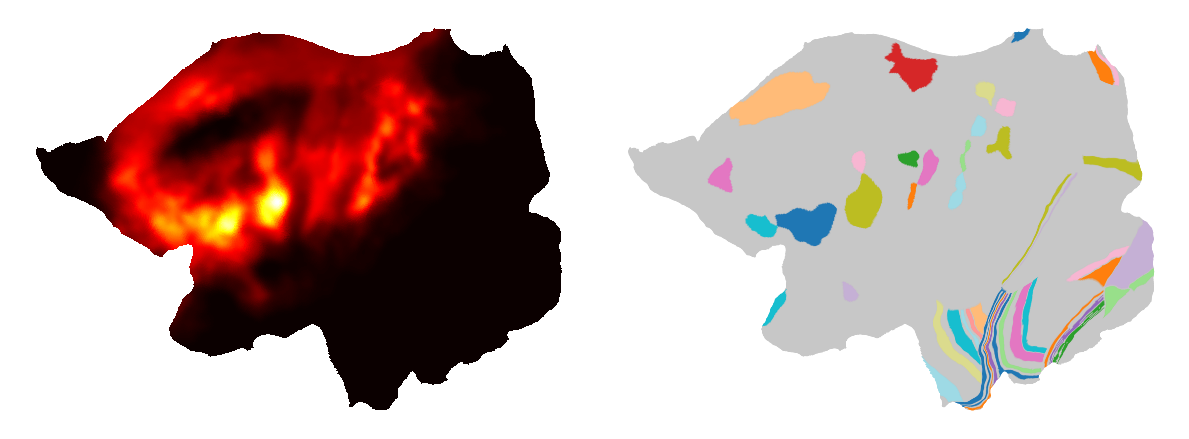

In [36]:
clusters = np.zeros_like(surf_map_data, dtype=np.uint32)
clusters[sorted_vertices] = sorted_vertex_clusters

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].tripcolor(flatsurf, surf_map_data, shading='flat', cmap=plt.cm.hot)
axes[0].axis('off')

no_cluster = (clusters == 0)
undefined_cluster = (clusters == 1)
clusters = np.mod(clusters-2,18)+2
clusters[no_cluster] = 0
clusters[undefined_cluster] = 1 

axes[1].tripcolor(flatsurf, clusters, shading='gouraud',vmin=0, vmax=20, cmap=cmap)
axes[1].axis('off')
# equal aspect ratio
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [11]:
from matplotlib.tri import Triangulation

flatsurf = Triangulation(vertices[:, 0], vertices[:, 1], faces)

# Mask zero values so they are not colored
cmap = plt.cm.tab20([15,14,0,2,4,6,8,10,12,16,18,1,3,5,7,9,11,13,17,19])
cmap = plt.cm.colors.ListedColormap(cmap)

for idx, clusters in enumerate(surf_cluster(surf_map_data, sorted_vertices, connectivity_list)):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))


    axes[0].tripcolor(flatsurf, surf_map_data, shading='flat', cmap=plt.cm.hot)
    axes[0].axis('off')
    
    no_cluster = (clusters == 0)
    undefined_cluster = (clusters == 1)
    clusters = np.mod(clusters-2,18)+2
    clusters[no_cluster] = 0
    clusters[undefined_cluster] = 1 
    
    axes[1].tripcolor(flatsurf, clusters, shading='gouraud',vmin=0, vmax=20, cmap=cmap)
    axes[1].axis('off')
    # equal aspect ratio
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    plt.tight_layout()
    plt.savefig(f'cluster_figures/clusters_{idx:04d}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    

    

: 

In [23]:
def surf_cluster_linkage(surf_map_data, sorted_vertices, connectivity_list, min_value=0):
    """ 
    Calculates a linkage matrix for surface clusters in scipy format.

    Assuming theta to be the largest threshold value such that regions with values greater or equal theta
    result in two vertices becoming connected. The distance between those two  vertices is defined as the larger
    of the two differences between each vertex value and the threshold theta.

    Computation is done in a single pass over the sorted vertices to be used as thresholds. Whenever thresholded
    regions become connected, the distance between all vertices in one region and all vertices in the other region
    is set to the distance defined above. 

    TODO: Explore alternative distance measures, e.g. the sum of the differences between the two vertex values
    and the threshold theta.
    """

    #sorted_vertices = sorted_vertices[:169]  # limit to first 10k vertices for testing
    
    # initialize condensed pairwise distance matrix
    n_vertices = len(sorted_vertices)
    Z = []

    # initialize clusters, leaf nodes indices are the indices of the sorted vertices
    clusters = np.zeros(len(surf_map_data), dtype=np.uint32)
    clusters[sorted_vertices] = np.arange(n_vertices, dtype=np.uint32)
    # define a mask of vertices that are valid leaf nodes
    mask = np.zeros(len(surf_map_data), dtype=bool)
    mask[sorted_vertices] = True
    # keep track of the leaf nodes that have been visited by lowering the threshold
    visited = np.zeros(len(surf_map_data), dtype=bool)
    # the first merged cluster index is set to the last leaf node index + 1 = n_vertices
    cluster_idx_merge = n_vertices 

    for vertex in sorted_vertices[surf_map_data[sorted_vertices] > min_value]:  
        theta = surf_map_data[vertex]
        
        # mark the leaf node associated with the current vertex as visited
        visited[vertex] = True

        # find all connected vertices in order to see whether they have been visited and thus
        # already belong to a cluster - if so, we first merge the current vertex with the cluster 
        # of the first connected vertex and then merge all other connected clusters, one by one
        connected_vertices = np.array(connectivity_list[vertex])
        connected_vertices = connected_vertices[visited[connected_vertices]]
        
        connected_cluster_idcs = np.unique(clusters[connected_vertices])
        # connection_distances = np.abs(surf_map_data[connected_vertices] - theta)
        # optionally: connected clusters could be sorted according to the values of connected vertices (value of difference to theta)

        # iteratively merge with all connected clusters
        cluster_idx_1 = clusters[vertex]
        for cluster_idx_2 in connected_cluster_idcs:
            # find all vertices belonging to the each cluster
            cluster_vertices_1 = np.where(np.logical_and(clusters == cluster_idx_1, visited))[0]
            cluster_vertices_2 = np.where(np.logical_and(clusters == cluster_idx_2, visited))[0]

            # calculate cluster distance as difference of the connected vertex values
            #d = np.min(connection_distances[connected_cluster_idcs == cluster_idx_2])
            # calculate cluster distance as the sum of the differences of each cluster maximum value and the threshold theta
            d = np.max(surf_map_data[cluster_vertices_1]) + np.max(surf_map_data[cluster_vertices_2]) - 2 * theta
            
            # merge clusters
            clusters[cluster_vertices_1] = cluster_idx_merge
            clusters[cluster_vertices_2] = cluster_idx_merge
        
            # number of vertices in the merged cluster
            n_vertices_merged = np.sum(np.logical_and(clusters == cluster_idx_merge, visited))

            # add the linkage information to the Z matrix

            # # first check that entry is valid
            # if cluster_idx_1 >= (n_vertices + len(Z)):
            #     raise ValueError(f"Cluster index {cluster_idx_1} is out of bounds for the number of clusters {n_vertices + Z.shape[0]}.")
            # if cluster_idx_2 >= (n_vertices + len(Z)):
            #     raise ValueError(f"Cluster index {cluster_idx_2} is out of bounds for the number of clusters {n_vertices + Z.shape[0]}.")
            # if cluster_idx_merge != (n_vertices + len(Z)):
            #     raise ValueError(f"Cluster index {cluster_idx_merge} is not equal to the number of clusters {n_vertices + Z.shape[0]}.")

            Z.append([cluster_idx_1, cluster_idx_2, d, n_vertices_merged])

            # prepare next iteration
            cluster_idx_1 = cluster_idx_merge
            cluster_idx_merge += 1
    Z = np.array(Z)
    return Z

In [127]:
Z = surf_cluster_linkage(surf_map_data, sorted_vertices, connectivity_list, min_value = 1)

In [130]:
Z

array([[1.00000000e+00, 0.00000000e+00, 1.47342682e-03, 2.00000000e+00],
       [2.00000000e+00, 1.49002000e+05, 2.89535522e-03, 3.00000000e+00],
       [3.00000000e+00, 1.49003000e+05, 6.48307800e-03, 4.00000000e+00],
       ...,
       [4.46750000e+04, 1.93674000e+05, 4.15689373e+00, 4.45570000e+04],
       [4.46760000e+04, 1.93675000e+05, 4.15690374e+00, 4.45580000e+04],
       [4.46770000e+04, 1.93676000e+05, 4.15690994e+00, 4.45590000e+04]],
      shape=(44676, 4))

In [131]:
# find a clustering by processing the linkage matrix Z
# we keep an array fclusters of length n_vertices, where each entry is the cluster index of the vertex
# we initialize fclusters with the vertex indices, i.e. fclusters[i] = im which is the leaf node index of the cluster
# we iterate over the linkage matrix Z, if the number of vertices in either of the clusters is less than the threshold, we merge and update fclusters
# otherwise we just keep the clusters as they are
min_cluster_size = 1000
n = len(sorted_vertices)
fclusters = np.arange(n, dtype=np.uint32)  # initialize with vertex indices
for i in range(len(Z))[:140000]:
    cluster_idx_1 = int(Z[i, 0])
    cluster_idx_2 = int(Z[i, 1])
    cluster_idx_merge = i + n
    n_vertices_1 = np.sum(fclusters == cluster_idx_1)
    n_vertices_2 = np.sum(fclusters == cluster_idx_2)
    # if either of the clusters has less than min_cluster_size vertices, merge them
    # and update fclusters
    if n_vertices_1 < min_cluster_size or n_vertices_2 < min_cluster_size:
            fclusters[fclusters == cluster_idx_1] = cluster_idx_merge
            fclusters[fclusters == cluster_idx_2] = cluster_idx_merge
    
print(f"Number of clusters after processing Z: {np.unique(fclusters).size}")

# sort unique values of fclusters and assign new cluster indices
unique_clusters = np.unique(fclusters)
fclusters_new = np.zeros_like(fclusters, dtype=np.uint32)
for i, cluster in enumerate(unique_clusters):
    fclusters_new[fclusters == cluster] = i


Number of clusters after processing Z: 104334


In [132]:
from matplotlib.tri import Triangulation

flatsurf = Triangulation(vertices[:, 0], vertices[:, 1], faces)

# Mask zero values so they are not colored
cmap = plt.cm.tab20([15,14,0,2,4,6,8,10,12,14,16,18,1,3,5,7,9,11,13,17,19])
cmap = plt.cm.colors.ListedColormap(cmap)


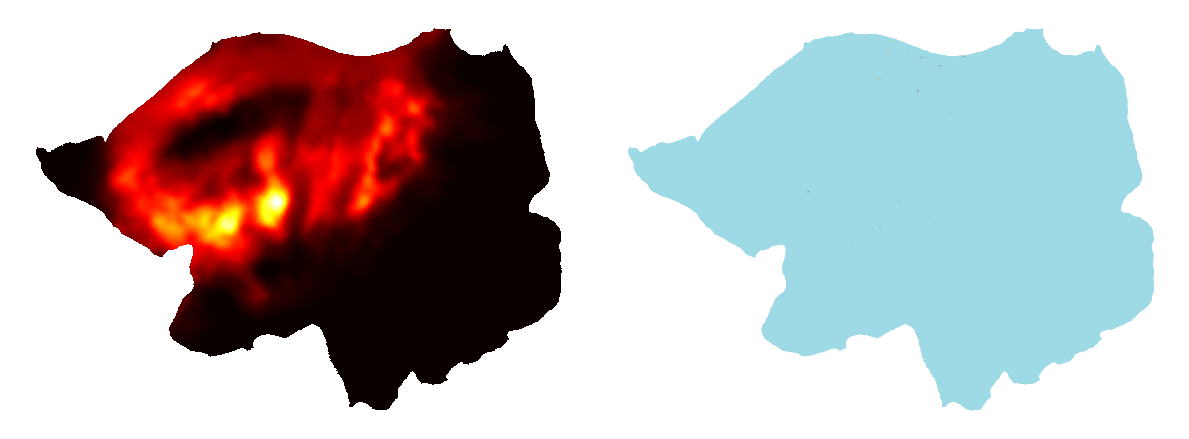

In [133]:
cluster_map = np.zeros(len(surf_map_data), dtype=np.int32)
cluster_map[sorted_vertices] = fclusters_new


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].tripcolor(flatsurf, surf_map_data, shading='flat', cmap=plt.cm.hot)
axes[0].axis('off')

#cluster_map = np.mod(saved_clusters[idx]-2,19)+2

axes[1].tripcolor(flatsurf, cluster_map, shading='gouraud',vmin=0, vmax=20, cmap=cmap)
axes[1].axis('off')
# equal aspect ratio
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [94]:
fclusters[fclusters == cluster_idx_1].size

1

In [ ]:
def fcluster(Z, min_cluster_size=100):
    """
    Extract clusters from the linkage matrix Z.
    Clusters with less than min_cluster_size vertices are not returned.
    """
    clusters = np.zeros(Z.shape[0] + 1, dtype=np.uint32)
    final_clusters = dict()
    
    for i, (c1, c2, d, n) in enumerate(Z):
        # if size of cluster to be merged is at least min_cluster_size,
        # then keep this cluster and add it to the final_clusters dict
        if n >= min_cluster_size:
            final_clusters[i] = np.where(clusters == i)[0]
        # merge clusters
        clusters[clusters == c1] = i + 1
        clusters[clusters == c2] = i + 1
    return clusters, final_clusters

In [389]:
n_vertices = len(sorted_vertices)
n_vertices

149002

In [79]:
np.max(Z[:, 2])

np.float64(5.526669979095459)

(array([2.8792e+04, 1.2390e+03, 9.4600e+02, 8.6300e+02, 1.0160e+03,
        1.2790e+03, 8.1600e+02, 8.2000e+02, 4.4900e+02, 4.0600e+02,
        3.3500e+02, 2.9600e+02, 3.1100e+02, 3.8200e+02, 4.1600e+02,
        3.9300e+02, 4.4300e+02, 4.5800e+02, 5.0700e+02, 3.9600e+02,
        2.8000e+02, 2.7400e+02, 2.9400e+02, 4.2400e+02, 8.4400e+02,
        8.8800e+02, 7.7500e+02, 9.0400e+02, 9.8000e+02, 9.3400e+02,
        5.8100e+02, 1.3400e+02, 1.2400e+02, 1.2600e+02, 1.1000e+02,
        1.6200e+02, 2.0700e+02, 2.1000e+02, 2.0400e+02, 1.9100e+02,
        1.8600e+02, 1.9300e+02, 2.1100e+02, 8.8000e+01, 3.5000e+01,
        5.4000e+01, 5.0000e+01, 4.5000e+01, 5.6000e+01, 5.6000e+01,
        6.4000e+01, 1.0200e+02, 2.8300e+02, 2.9600e+02, 3.1500e+02,
        3.9100e+02, 3.4800e+02, 3.2000e+02, 4.3900e+02, 4.6000e+02,
        4.8400e+02, 5.3300e+02, 4.9200e+02, 5.0500e+02, 5.5100e+02,
        5.4900e+02, 5.8800e+02, 6.3200e+02, 9.8400e+02, 1.5470e+03,
        1.8740e+03, 1.9740e+03, 2.2020e+03, 2.78

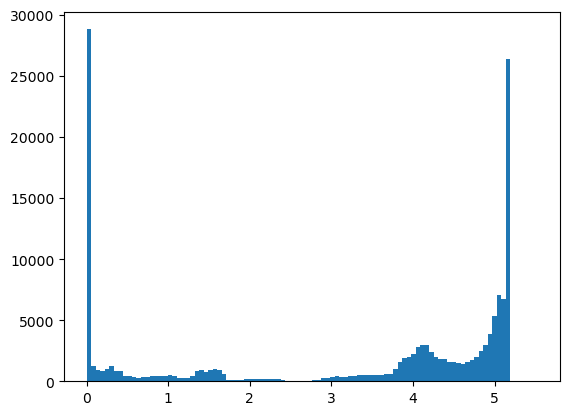

In [76]:
plt.hist(Z[:,2], bins=100)

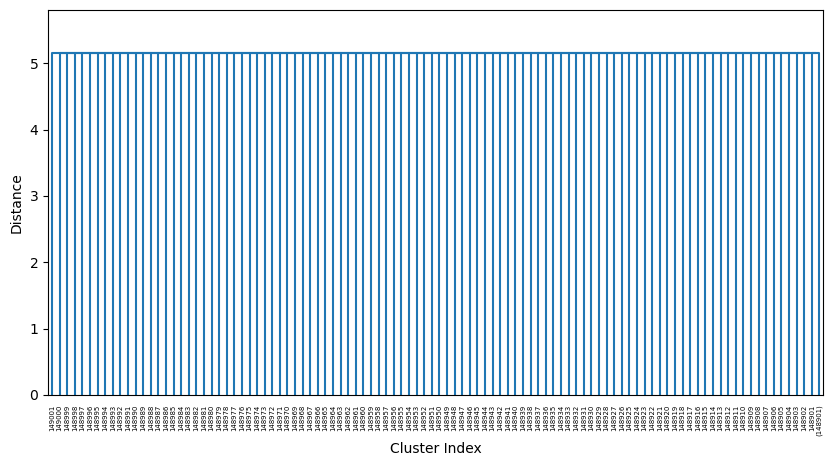

In [370]:
from scipy.cluster.hierarchy import dendrogram, fcluster
plt.figure(figsize=(10, 5))
#dendrogram(Z,truncate_mode='level', p=3, color_threshold=0.5, leaf_font_size=10, leaf_rotation=90) 
dendrogram(Z, truncate_mode='level', p=100)
#dendrogram(Z)
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()


In [33]:
from scipy.cluster.hierarchy import dendrogram, fcluster, cophenet, inconsistent, to_tree


In [73]:
fclusters = fcluster(Z, t=100000, criterion='maxclust')
np.unique(fclusters)

array([    1,     2,     3, ..., 89946, 89947, 89948],
      shape=(89948,), dtype=int32)

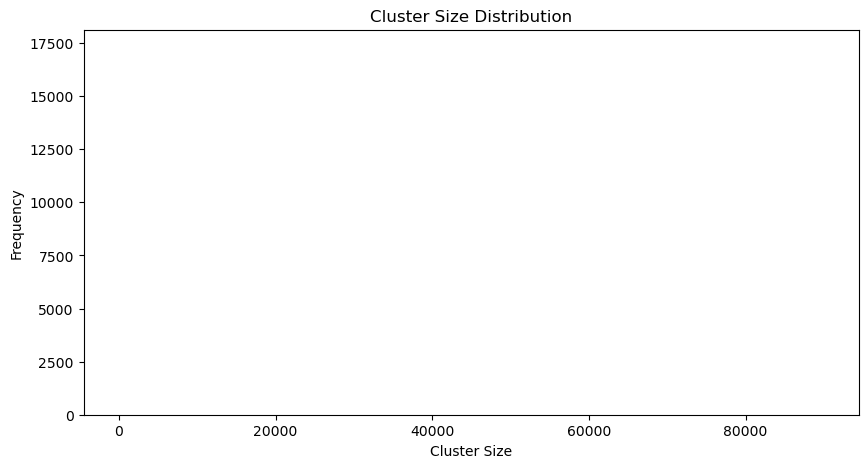

In [64]:

plt.figure(figsize=(10, 5))
plt.hist(fclusters, bins=np.arange(1, np.max(fclusters) + 2) - 0.5, rwidth=0.8)
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
plt.title('Cluster Size Distribution')
plt.show()

In [38]:
np.unique(fclusters)

array([    1,     2,     3, ..., 98648, 98649, 98650],
      shape=(98650,), dtype=int32)

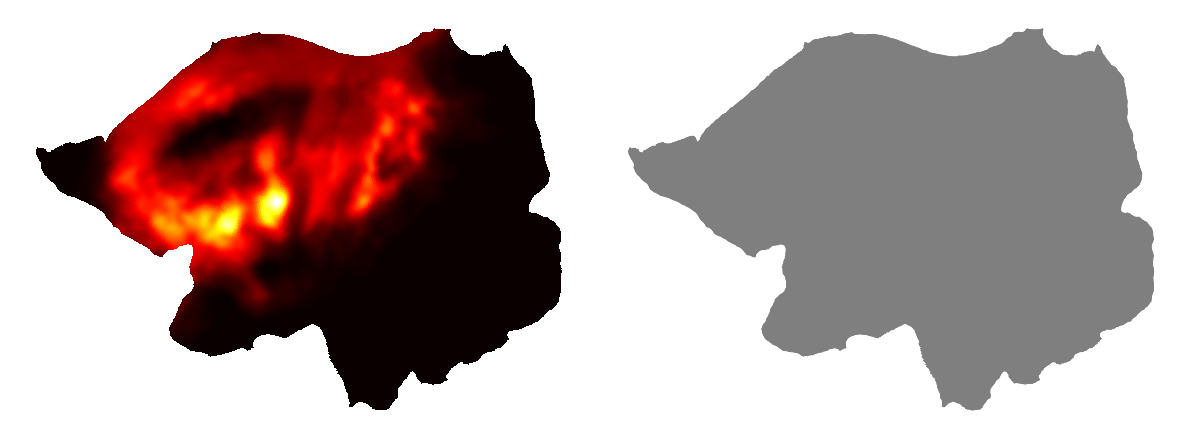

In [373]:
fc = fcluster(Z, t=30)
cluster_map = np.zeros(len(surf_map_data), dtype=np.int32)
cluster_map[sorted_vertices] = fc


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].tripcolor(flatsurf, surf_map_data, shading='flat', cmap=plt.cm.hot)
axes[0].axis('off')

#cluster_map = np.mod(saved_clusters[idx]-2,19)+2

axes[1].tripcolor(flatsurf, cluster_map, shading='gouraud',vmin=0, vmax=20, cmap=cmap)
axes[1].axis('off')
# equal aspect ratio
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [ ]:

# Extract clusters from the linkage matrix
clusters = fcluster(Z, t=0.1, criterion='distance')
# Plot the clusters on the surface
plotting.plot_surf(surf_path, surf_map_data, 
                   title='Surface Clusters', 
                   threshold=0.1, 
                   cmap='viridis', 
                   colorbar=True, 
                   bg_map=surf_map_path,
                   view='lateral',
                   figure_size=(10, 5))
# Plot the clusters on the surface
plotting.plot_surf(surf_path, clusters, 
                   title='Surface Clusters', 
                   cmap='viridis', 
                   colorbar=True, 
                   bg_map=surf_map_path,
                   view='lateral',
                   figure_size=(10, 5))
# Plot the clusters on the surface
plotting.plot_surf(surf_path, clusters, 
                   title='Surface Clusters', 
                   cmap='viridis', 
                   colorbar=True, 
                   bg_map=surf_map_path,
                   view='medial',
                   figure_size=(10, 5))
# Plot the clusters on the surface
plotting.plot_surf(surf_path, clusters, 
                   title='Surface Clusters', 
                   cmap='viridis', 
                   colorbar=True, 
                   bg_map=surf_map_path,
                   view='dorsal',
                   figure_size=(10, 5))
# Plot the clusters on the surface
plotting.plot_surf(surf_path, clusters, 
                   title='Surface Clusters', 
                   cmap='viridis', 
                   colorbar=True, 
                   bg_map=surf_map_path,
                   view='ventral',
                   figure_size=(10, 5))
# Plot the clusters on the surface
plotting.plot_surf(surf_path, clusters, 
                   title='Surface Clusters', 
                   cmap='viridis', 
                   colorbar=True, 
                   bg_map=surf_map_path,
                   view='anterior',
                   figure_size=(10, 5))
# Plot the clusters on the surface
plotting.plot_surf(surf_path, clusters, 
                   title='Surface Clusters', 
                   cmap='viridis', 
                   colorbar=True, 
                   bg_map=surf_map_path,
                   view='posterior',
                   figure_size=(10, 5))
# Plot the clusters on the surface


In [20]:
# using a numpy array to store clusters, addditional speed up of ~4x
n_vertices = vertices.shape[0]

min_value = np.median(surf_map_data[sorted_vertices])

# we start with an empty list of clusters and iterate over the sorted indices
clusters = np.zeros(n_vertices, dtype=np.uint32)
saved_clusters = []
final_clusters = dict()
#l = []
final_vertices = set()

for i,vertex in enumerate(sorted_vertices):
    # if value of vertex < min_value, leave the loop
    if surf_map_data[vertex] < min_value:
        break
    # Check if the current vertex is connected to any existing cluster
    # merge all connected clusters and add the current vertex to it
    connected_vertices = connectivity_list[vertex]
    connected_cluster_idcs = clusters[connected_vertices]
    clusters, new_final_clusters = merge_clusters_nparray(clusters, connected_cluster_idcs, vertex,
                                                          min_cluster_size=400)
    # merge dict of final clusters
    for new_final_cluster_idx in new_final_clusters.keys():
        # test 
        if not np.isin(new_final_clusters[new_final_cluster_idx], list(final_vertices)).any():
            final_vertices.update(new_final_clusters[new_final_cluster_idx])
            final_clusters[new_final_cluster_idx] = new_final_clusters[new_final_cluster_idx]
    #final_clusters.update(new_final_clusters)
    if (i % 500) == 0 or new_final_clusters:
        clusters_map = (clusters>0) * 1
        for cluster_idx in final_clusters.keys():
            clusters_map[final_clusters[cluster_idx]] = cluster_idx 
        saved_clusters.append(clusters_map)

    #l.append(len(np.unique(clusters))-1)
#plt.plot(l)


In [21]:
len(final_clusters)

8

In [79]:
final_vertices

{np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(139),
 np.int64(140),
 np.int64(141),
 np.int64(142),
 np.int64(143),
 np.int64(144),
 np.int64(145),
 np.int64(146),
 np.int64(147),
 np.int64(148),
 np.int64(149),
 np.int64(150),
 np.int64(151),
 np.int64(152),
 np.int64(153),
 np.int64(154),
 np.int64(155),
 np.int64(156),
 np.int64(157),
 np.int64(158),
 np.int64(159),
 np.int64(160),
 np.int64(161),
 np.int64(162),
 np.int64(163),
 np.int64(164),
 np.int64(165),
 np.int64(166),
 np.int64(167),
 np.int64(168),
 np.int64(169),
 np.int64(170),
 np.int64(171),
 np.int64(172),
 np.int64(173),
 np.int64(174),
 np.int64(175),
 np.int64(17

In [72]:
len(final_clusters)

622

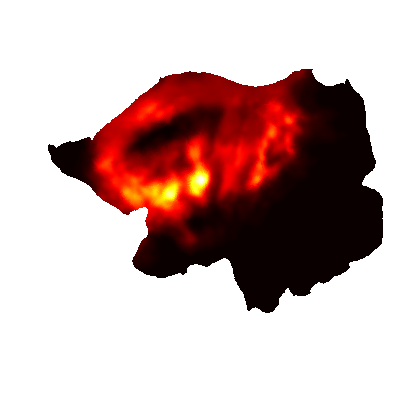

In [11]:
plotting.plot_surf(surf_path,surf_map_data,threshold=0,symmetric_cmap=False, 
                   cmap=plt.cm.hot,colorbar=False, view=[90,-90])
plt.show()

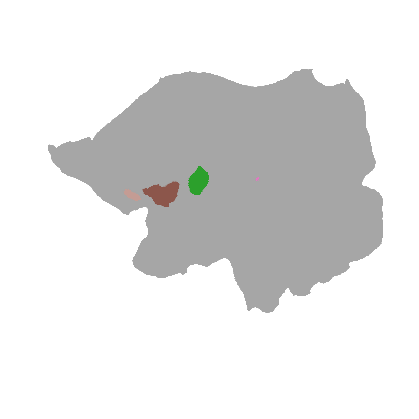

In [23]:
plotting.plot_surf(surf_path,saved_clusters[30],threshold=0.1,symmetric_cmap=False, 
                    cmap=plt.cm.tab20,colorbar=False, vmax=20,view=[90,-90], 
                    avg_method='median')
plt.show()

In [36]:
np.unique(saved_clusters[30])

array([ 0,  1, 27, 29])

In [25]:
len(saved_clusters)

14901

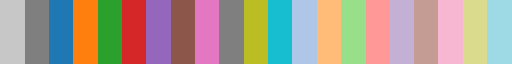

In [26]:
cmap

In [49]:
np.unique(saved_clusters[5])

array([0, 1, 2])

In [168]:
from matplotlib.tri import Triangulation

flatsurf = Triangulation(vertices[:, 0], vertices[:, 1], faces)

# Mask zero values so they are not colored
cmap = plt.cm.tab20([15,14,0,2,4,6,8,10,12,14,16,18,1,3,5,7,9,11,13,17,19])
cmap = plt.cm.colors.ListedColormap(cmap)



In [ ]:
for idx in range(len(saved_clusters)):
# create figure with two subplots
#    if idx % 10 == 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].tripcolor(flatsurf, surf_map_data, shading='flat', cmap=plt.cm.hot)
    axes[0].axis('off')
    
    cluster_map = np.mod(saved_clusters[idx]-2,19)+2
    cluster_map[saved_clusters[idx] == 0] = 0  # Mask zero values
    cluster_map[saved_clusters[idx] == 1] = 1  # Mask zero values
    
    axes[1].tripcolor(flatsurf, cluster_map, shading='gouraud',vmin=0, vmax=20, cmap=cmap)
    axes[1].axis('off')
    # equal aspect ratio
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    plt.tight_layout()
    plt.savefig(f'cluster_figures/clusters_{idx:04d}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

In [2]:
# make gif
from PIL import Image
import glob
import time

# create an empty list called images
images = []

# get the current time to use in the filename
timestr = time.strftime("%Y%m%d-%H%M%S")

# get all the images in the folder
for filename in sorted(glob.glob('cluster_figures/clusters_*.png')): # loop through all png files in the folder
    im = Image.open(filename) # open the image
    im_small = im.resize((714, 263), resample=0) # resize them to make them a bit smaller
    images.append(im_small) # add the image to the list

# calculate the frame number of the last frame (ie the number of images)
last_frame = (len(images)) 
#3570x1317(orig)

# create 10 extra copies of the last frame (to make the gif spend longer on the most recent data)
for x in range(0, 9):
    im = images[last_frame-1]
    images.append(im)

# save as a gif   
images[0].save('clusters_animated.gif', format='GIF',
               save_all=True, append_images=images[1:], optimize=False, duration=100, loop=1)